<a href="https://colab.research.google.com/github/hamidriasat/-Computer-Vision-and-Deep-Learning/blob/master/Incident_Project_Oversampling_XLnet_Finetune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#  To get additional memory/ram
# a = []
# while(1):
    # a.append("1")

In [ ]:
!pip install pytorch-transformers


In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from pytorch_transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from pytorch_transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

from collections import Counter


Using TensorFlow backend.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

In [ ]:
!gdown --id 1v21uOScs8OScfkldm_7KjpN4zj-S-VI6

!unzip OverAllDataset


Downloading...
From: https://drive.google.com/uc?id=1v21uOScs8OScfkldm_7KjpN4zj-S-VI6
To: /content/OverAllDataset.zip
100% 1.15M/1.15M [00:00<00:00, 76.5MB/s]
Archive:  OverAllDataset.zip
   creating: OverAllDataset/
  inflating: OverAllDataset/1.txt    
  inflating: OverAllDataset/10.txt   
  inflating: OverAllDataset/100.txt  
  inflating: OverAllDataset/1000.txt  
  inflating: OverAllDataset/1001.txt  
  inflating: OverAllDataset/1002.txt  
  inflating: OverAllDataset/1003.txt  
  inflating: OverAllDataset/1004.txt  
  inflating: OverAllDataset/1005.txt  
  inflating: OverAllDataset/1006.txt  
  inflating: OverAllDataset/1007.txt  
  inflating: OverAllDataset/1008.txt  
  inflating: OverAllDataset/1009.txt  
  inflating: OverAllDataset/101.txt  
  inflating: OverAllDataset/1010.txt  
  inflating: OverAllDataset/1011.txt  
  inflating: OverAllDataset/1012.txt  
  inflating: OverAllDataset/1013.txt  
  inflating: OverAllDataset/1014.txt  
  inflating: OverAllDataset/1015.txt  
  infla

In [ ]:
# Set the maximum sequence length. 
MAX_LEN = 250

def readLabels():
  full_labels= []
  with open( "OverAllDataset/Labels.txt" , encoding="cp1252") as content_file:
    for line in content_file:
      full_labels.append( int(line))
  return full_labels

def readData( ):
    full_date= []
    for i in range(1, 1262):
        with open( "OverAllDataset/"+ str(i) + ".txt" , encoding="cp1252") as content_file:
            fileData= content_file.read()
            templength= len(fileData.split() )
            if templength < MAX_LEN:
                full_date.append(fileData )
            else:
                temp= ""
                convert= fileData.split()
                for j in range(0, MAX_LEN):
                    temp= temp+ " "+convert[j]
                full_date.append(temp )

    return full_date


data_X= readData()
data_Y= readLabels()

print(len(data_X))
print(len(data_Y))

1261
1261


In [ ]:
for k in range(1255, 1261): 
  print(data_Y[k])


1
0
3
4
0
0


In [ ]:
sentences = data_X
# labels = data_Y


In [ ]:
# merging category 4 and 5 as 5
labels = []
for value in data_Y:
  if value == 5:
    labels.append(4)
  else:
    labels.append(value)

In [ ]:
#  get number of occurrences for each element
Counter( labels )

Counter({0: 256, 1: 337, 2: 140, 3: 261, 4: 267})

In [ ]:
sentences = [sentence + " [SEP] [CLS]" for sentence in sentences]


In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)
# tokenizer = XLNetTokenizer.from_pretrained('xlnet-large-cased', do_lower_case=True)

100%|██████████| 798011/798011 [00:00<00:00, 5433190.53B/s]


In [ ]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁driver', '▁dead', '▁after', '▁crash', '▁with', '▁', 'georgia', '▁school', '▁bus', '▁carrying', '▁kids', '▁', 'g', 'win', 'nett', '▁county', ',', '▁', 'ga', '.', '▁', '-', '-', '▁police', '▁in', '▁', 'georgia', '▁say', '▁the', '▁driver', '▁of', '▁an', '▁', 's', 'uv', '▁has', '▁been', '▁killed', '▁in', '▁a', '▁crash', '▁with', '▁a', '▁bus', '▁carrying', '▁five', '▁elementary', '▁school', '▁students', '.', '▁in', '▁a', '▁statement', '▁posted', '▁to', '▁twitter', '▁by', '▁', 'g', 'win', 'nett', '▁police', ',', '▁officers', '▁confirmed', '▁none', '▁of', '▁the', '▁students', '▁were', '▁hurt', '.', '▁the', '▁bus', '▁driver', '▁suffered', '▁a', '▁minor', '▁injury', '▁but', '▁was', '▁not', '▁taken', '▁to', '▁a', '▁hospital', '.', '▁news', '▁outlets', '▁reported', '▁the', '▁', 's', 'uv', '▁crashed', '▁into', '▁the', '▁', 'g', 'win', 'nett', '▁county', '▁bus', '▁just', '▁after', '▁3', '▁p', '.', 'm', '.', '▁at', '▁an', '▁intersection', '▁about', '▁40', '▁miles', '▁

In [ ]:

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]


In [ ]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
len(input_ids)

1261

In [ ]:
# upsampling before split
from sklearn.utils import resample
from imblearn.over_sampling import (RandomOverSampler)
sampler = RandomOverSampler()
input_ids, labels = sampler.fit_sample(input_ids, labels)
print('RandomOverSampler {}'.format(Counter(labels)))
print(len(input_ids))
print(len(labels))

# from imblearn.over_sampling import SMOTE
# sampler = SMOTE(ratio='minority')
# input_ids, labels = sampler.fit_sample(input_ids, labels)
# print('RandomOverSampler {}'.format(Counter(labels)))
# print(len(input_ids))
# print(len(labels))

RandomOverSampler Counter({3: 337, 1: 337, 2: 337, 4: 337, 0: 337})
1685
1685


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [ ]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.2)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [ ]:
# # upsampling after split

# from sklearn.utils import resample
# from imblearn.over_sampling import (RandomOverSampler)

# sampler = RandomOverSampler( random_state=0)

# train_masks, temp_labels = sampler.fit_sample(train_masks, train_labels)
# print('RandomOverSampler {}'.format(Counter(temp_labels)))
# print(len(train_masks))
# print(len(temp_labels))

In [ ]:

# train_inputs, train_labels = sampler.fit_sample(train_inputs, train_labels)
# print('RandomOverSampler {}'.format(Counter(train_labels)))
# print(len(train_inputs))
# print(len(train_labels))

In [ ]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [ ]:
# Select a batch size for training. For fine-tuning with XLNet, 
# the authors recommend a batch size of 32, 48, or 128.
#  We will use 32 here to avoid memory issues.
batch_size = 16


# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


In [ ]:
# Load XLNEtForSequenceClassification, the pretrained XLNet model with a single linear classification layer on top. 

model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=5)
# model = XLNetForSequenceClassification.from_pretrained("xlnet-large-cased", num_labels=6)

model.cuda()

In [ ]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]


In [ ]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [ ]:
# Function to calculate the accuracy of our predictions vs labels
class Record():
  def __init__(self ):
    self.first_preds = []
    self.second_preds = []
    self.third_preds = []
    self.fourth_preds = []

    self.first_labels = []
    self.second_labels = []
    self.third_labels = []
    self.fourth_labels = []
    self.first_loss = 0.0
    self.second_loss = 0.0
    self.third_loss = 0.0
    self.fourth_loss = 0.0

def flat_accuracy(preds, labels, epoch_num, record):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    temp_loss = np.sum(pred_flat == labels_flat) / len(labels_flat)
    # print(pred_flat)
    # print(type(pred_flat))
    # print()
    # print(record.first_preds)
    if epoch_num == 0 :
      record.first_preds += list(pred_flat)
      record.first_labels += list(labels_flat)
      record.first_loss += temp_loss
    elif epoch_num == 1:
      record.second_preds += list(pred_flat)
      record.second_labels += list(labels_flat)
      record.second_loss += temp_loss
    elif epoch_num == 2 :
      record.third_preds += list(pred_flat)
      record.third_labels += list(labels_flat)
      record.third_loss += temp_loss
    elif epoch_num == 3 :
      record.fourth_preds += list(pred_flat)
      record.fourth_labels += list(labels_flat)
      record.fourth_loss += temp_loss
    
    return temp_loss, record

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
record = Record()

# Store our loss and accuracy for plotting
train_loss_set = []

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Measure the total training time for the whole run.
total_t0 = time.time()


# trange is a tqdm wrapper around the normal python range
for epoch_i in range(0, epochs):
  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

  t0 = time.time()

  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()

  # Reset the total loss for this epoch.
  total_train_loss = 0
  
  # # Tracking variables
  # tr_loss = 0
  # nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):

    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())  
    # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
    total_train_loss += loss.item()
  
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    
    # Update tracking variables
    # tr_loss += loss.item()
    # nb_tr_examples += b_input_ids.size(0)
    # nb_tr_steps += 1
  # print("Train loss: {}".format(tr_loss/nb_tr_steps))

  # Calculate the average loss over all of the batches.
  avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))
  print("  Training epcoh took: {:}".format(training_time))

  t0 = time.time()
    
    
  # Validation
  print("")
  print("Running Validation...")

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0
  
  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs  = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
      loss = outputs[0]
      logits = outputs[1]

    # Accumulate the validation loss.
    total_eval_loss += loss.item()    
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    batch_accuracy, record = flat_accuracy(logits, label_ids, epoch_i, record)
    total_eval_accuracy += batch_accuracy
    
    # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)
    
  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Valid. Accur.': avg_val_accuracy,
          'Training Time': training_time,
          'Validation Time': validation_time
      }
  )
    
  # print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))


======== Epoch 1 / 4 ========
Training...

  Average training loss: 1.55
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.43
  Validation Loss: 1.35
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...

  Average training loss: 1.10
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.69
  Validation Loss: 0.89
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...

  Average training loss: 0.71
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.74
  Validation Loss: 0.82
  Validation took: 0:00:05

======== Epoch 4 / 4 ========
Training...

  Average training loss: 0.49
  Training epcoh took: 0:01:05

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.83
  Validation took: 0:00:05


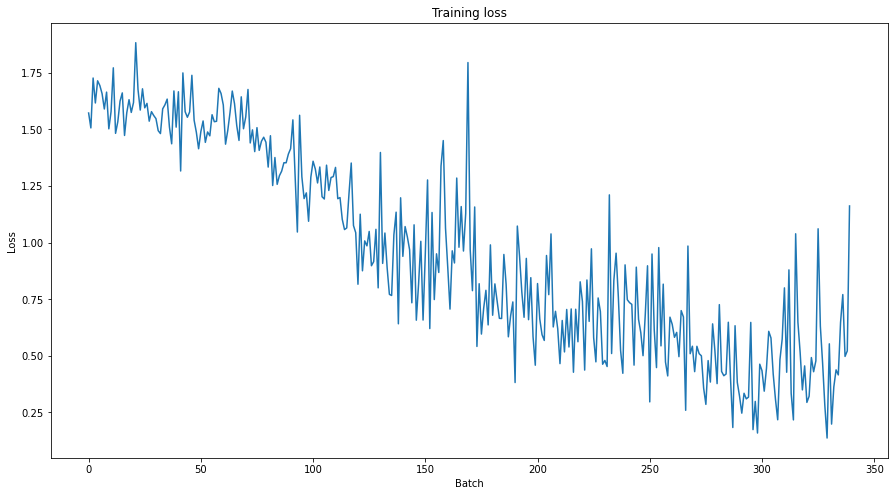

In [ ]:
# Let’s take a look at our training loss over all batches:

plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.55,1.35,0.43,0:01:05,0:00:05
2,1.10,0.89,0.69,0:01:05,0:00:05
3,0.71,0.82,0.74,0:01:05,0:00:05
4,0.49,0.83,0.75,0:01:05,0:00:05


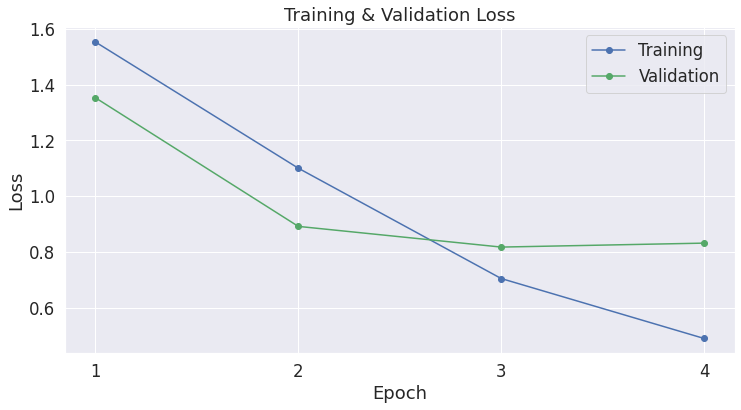

In [ ]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
from sklearn.metrics import classification_report

conf_mat = classification_report(  record.fourth_labels, record.fourth_preds,) 
print( conf_mat)



              precision    recall  f1-score   support

           0       0.81      0.72      0.76        78
           1       0.65      0.53      0.58        59
           2       0.71      0.94      0.81        71
           3       0.80      0.62      0.70        66
           4       0.73      0.86      0.79        63

    accuracy                           0.74       337
   macro avg       0.74      0.73      0.73       337
weighted avg       0.74      0.74      0.73       337



In [ ]:
unmatch_count= 0
for actual_label, pred_label in zip(record.fourth_labels, record.fourth_preds):
  if actual_label != pred_label:
    unmatch_count += 1
    print(actual_label, pred_label)

print("not matched count", (unmatch_count/ len(record.fourth_labels)))
   


In [ ]:
from sklearn.metrics import matthews_corrcoef

print('Matthews Corr. Coef.')
matthews = matthews_corrcoef( record.fourth_labels, record.fourth_preds )                
print(matthews)

Calculating Matthews Corr. Coef. for each batch...
0.6768211039422115


In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/spiece.model',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/My Drive/IncidentProject/"
# !cp -r ./model_save/ https://drive.google.com/open?id=1jFVkdHjKY_CZ0nRhYp6-FphZaD_ifvYr